Setup

In [12]:
import os
import copy
import pickle

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Sampler

from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.patches import Rectangle

import FrEIA.framework as Ff
import FrEIA.modules as Fm

from tqdm import tqdm


Dataset

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TactileMaterialDataset(Dataset):
    def __init__(self, file_path, material = None):

        with h5py.File(file_path, 'r') as dataset:
            raw_samples = dataset['samples'][:] / 154.  # Normalize
            materials = [i.decode() for i in dataset['materials'][:]]  # Decode material names
        
        if material is not None:
            self.samples = raw_samples[material, :, :, :, :].reshape(1, 100, 16, 1000).reshape(-1, 1000)
            materials = np.array([1])

        else:
            self.samples = raw_samples.reshape(36, 100, 16, 1000).reshape(-1, 1000)

        # Apply FFT along the last axis and separate real & imaginary parts
        fft_transformed = np.fft.rfft(self.samples, axis=1)
        self.samples = np.stack((fft_transformed.real, fft_transformed.imag), axis=0) 
        self.samples = self.samples.reshape(-1, 1002)

        self.samples = torch.tensor(self.samples, dtype=torch.float32) 
        self.labels = torch.tensor(np.repeat(range(len(materials)), 100*16)) 
            
        # np.fft.fft
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

class ContiguousBatchSampler(Sampler):
    # sampler to ensure that every batch contains the 16 sub samples from the same sample
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        self.batches = [self.indices[i:i+batch_size] for i in range(0, len(dataset), batch_size)]
    
    def __iter__(self):
        np.random.shuffle(self.batches)  # Shuffle order
        for batch in self.batches:
            yield batch
    
    def __len__(self):
        return len(self.batches)


Stuff needed for Training

In [42]:
# Construction of the INN and GMM

def subnet_fc(dims_in, dims_out, hidden_layer_size=512):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_size), 
                         nn.ReLU(),
                         nn.Linear(hidden_layer_size,  dims_out),
                         )

class SwapPermutationAllInOneBlock(Fm.AllInOneBlock):
    def __init__(self, dims_in, dims_c=[], subnet_constructor=None, **kwargs):
        if subnet_constructor is None:
            raise ValueError("A subnet_constructor must be provided.")
        super(SwapPermutationAllInOneBlock, self).__init__(dims_in, dims_c, subnet_constructor, **kwargs)

    def _permute(self, x, rev=False): #swap permute
        mid = x.size(1) // 2
        swapped = torch.cat([x[:, mid:], x[:, :mid]], dim=1)
        return swapped, 0

class ClassConditionalGMM(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super(ClassConditionalGMM, self).__init__() 
        init_scale = 1.0 / np.sqrt(2 * (latent_dim // n_classes))
        self.mu = nn.Parameter(torch.zeros(1, n_classes, latent_dim))
        for k in range(latent_dim // n_classes):
            # self.mu.data[0, :, n_classes * k: n_classes * (k + 1)] = init_scale * torch.eye(n_classes)
            self.mu = nn.Parameter(0.1 * torch.randn(1, n_classes, latent_dim)) # init mu randomly, not with identity matrix as above
        self.logvar = torch.full((n_classes, latent_dim), 1.0) # fixed log-variance

    def forward(self, z):
        # Compute log-probabilities for each class
        z_expanded = z.unsqueeze(1)
        mu = self.mu.unsqueeze(0)
        logvar = self.logvar.to(device).unsqueeze(0)
        log_p = -0.5 * (logvar + (z_expanded - mu)**2 / logvar.exp()) # the core log gaussian density
        return log_p.sum(dim=-1).log_softmax(dim=-1)  # normalize to get valid probabilities



Loss

In [43]:

def cluster_distances(z, mu):
    z_i_z_i = torch.sum(z**2, dim=1, keepdim=True)  # squared norm of each latent vector
    mu_j_mu_j = torch.sum(mu**2, dim=2)             # squared norm of each cluster center
    z_i_mu_j = torch.mm(z, mu.squeeze().t())        # inner product between z_i and mu_j

    return -2 * z_i_mu_j + z_i_z_i + mu_j_mu_j # returns the squared euclidean distance between z_i and mu_j    


def information_bottleneck_loss(x, y, model, gmm, beta=1.0):

    z, log_detJ = model(x)  # gets the latent vector and the log determinant of the Jacobian
    dist = cluster_distances(z, gmm.mu)  # see above...

    # gen loss
    nll_joint = -torch.logsumexp(-0.5 * dist, dim=1) - log_detJ # negative log likelihood
    L_gen_batch = nll_joint.mean() / z.shape[1] # average over the latent dimensions

    # cls loss
    logits = -0.5 * dist  # logits are the negative distances
    L_cls_batch = F.cross_entropy(logits, y.to(device)) # cross entropy loss

    L_gen = L_gen_batch.mean() # average over the batch
    L_cls = L_cls_batch.mean() 
    L_total = L_gen + beta * L_cls # total loss

    return L_total, logits, L_gen, L_cls


Training

In [44]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import copy

def train_inn_gmm(
    dataset_path,          
    n_coupling_blocks=2,
    epochs=20,
    beta=0.75,
    lr=0.001,
    lr_mu=0.0001,
    weight_decay=1e-5,
    train_split=0.8,
    n_classes=36,
    hidden_layer_size=512,
    patience=5,
    swap_permute=True,
    batch_size = 16,
    N_DIM = 1002
):



    #Get dataset

    full_dataset = TactileMaterialDataset(dataset_path)
    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    # Create DataLoaders
    train_sampler = ContiguousBatchSampler(train_subset, batch_size)
    train_loader = DataLoader(train_subset, batch_sampler=train_sampler, shuffle=False)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
    
    torch.cuda.empty_cache() # for memory reasons

    # Initialize the INN and GMM
    inn = Ff.SequenceINN(N_DIM).to(device)
    for k in range(n_coupling_blocks):

        # enable swap permutation or random permutation
        if swap_permute==True:
            inn.append(SwapPermutationAllInOneBlock, 
                    subnet_constructor=lambda dims_in, dims_out: subnet_fc(dims_in, dims_out, hidden_layer_size=hidden_layer_size))
        else:
            inn.append(Fm.AllInOneBlock, 
                    subnet_constructor=lambda dims_in, dims_out: subnet_fc(dims_in, dims_out, hidden_layer_size=hidden_layer_size), permute_soft=True)


    gmm = ClassConditionalGMM(n_classes=n_classes, latent_dim=N_DIM).to(device)



    optimizer = torch.optim.Adam([
        {'params': inn.parameters(), 'lr': lr, 'weight_decay': weight_decay},
        {'params': gmm.mu, 'lr': lr_mu, 'weight_decay': 0.0}
    ])

    # send models to CUDA
    inn.to(device)
    gmm.to(device)

    # initialize losses and accuracies
    train_losses   = []
    val_losses     = []
    val_accs       = []
    val_accs_top5  = []
    
    # Early-stopping variables
    best_val_acc = 0
    patience_counter = 0
    best_inn_state = copy.deepcopy(inn.state_dict())
    best_gmm_state = copy.deepcopy(gmm.state_dict())

    # Training Loop
    print("Starting training loop...")

    for epoch in range(epochs):
        inn.train()
        train_loss_epoch = 0.0
        
        for x_batch, c_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            optimizer.zero_grad()
            
            loss, _, _, _ = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
            train_loss_epoch += loss.item()
            
            loss.backward()
            optimizer.step()
        
        train_loss_epoch /= len(train_loader)
        # add to the list of losses
        train_losses.append(train_loss_epoch)
        
        # Val
        inn.eval()
        val_loss_epoch = 0.0
        correct_top1 = 0
        total_samples = 0
        
        with torch.no_grad():
            for x_batch, c_batch in val_loader:
                x_batch = x_batch.to(device)
                c_batch = c_batch.to(device)
                
                loss, logits, L_gen, L_cls = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
                val_loss_epoch += loss.item()
                
                preds = logits.argmax(dim=1)
                correct_top1 += (preds == c_batch).sum().item()
                
                total_samples += c_batch.size(0)
        
        val_loss_epoch /= len(val_loader)
        val_losses.append(val_loss_epoch)
        
        val_acc = correct_top1 / total_samples
        val_accs.append(val_acc)
        
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss_epoch:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, "
              f"Val Acc: {val_acc:.4f}, "
              f"L_gen mean: {L_gen.mean():.4f}, "
              f"L_cls mean: {L_cls.mean():.4f} "
        )
        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            
            best_inn_state = copy.deepcopy(inn.state_dict())
            best_gmm_state = copy.deepcopy(gmm.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
    
    inn.load_state_dict(best_inn_state)
    gmm.load_state_dict(best_gmm_state)

    print("Training complete, Best Accuracy: ", best_val_acc)

    torch.save(best_inn_state, "best_inn.pth")
    torch.save(best_gmm_state, "best_gmm.pth")

    
    logs = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_accs_top5': val_accs_top5,
    }

    return inn, gmm, logs


In [46]:
# Train the model

inn, gmm, logs = train_inn_gmm(
    dataset_path = 'data/raw/tactmat.h5',
    n_coupling_blocks=4,
    epochs=20,
    beta=3,
    lr=0.001,
    lr_mu=0.001,
    weight_decay=1e-4,
    hidden_layer_size=512,
    patience=5,
    swap_permute=False,
)

Starting training loop...


[Epoch 1/20] Train Loss: 9.4058, Val Loss: 7.9885, Val Acc: 0.2126, L_gen mean: 0.3614, L_cls mean: 2.7563 


[Epoch 2/20] Train Loss: 7.7461, Val Loss: 7.6308, Val Acc: 0.2482, L_gen mean: 0.4076, L_cls mean: 2.4596 


[Epoch 3/20] Train Loss: 7.1773, Val Loss: 7.5470, Val Acc: 0.2693, L_gen mean: 0.5632, L_cls mean: 2.3141 


[Epoch 4/20] Train Loss: 6.8960, Val Loss: 7.3317, Val Acc: 0.2904, L_gen mean: 0.6946, L_cls mean: 2.3466 


[Epoch 5/20] Train Loss: 6.6379, Val Loss: 7.3107, Val Acc: 0.3040, L_gen mean: 0.7679, L_cls mean: 2.0528 


[Epoch 6/20] Train Loss: 6.3517, Val Loss: 7.2645, Val Acc: 0.3260, L_gen mean: 0.8101, L_cls mean: 2.0034 


[Epoch 7/20] Train Loss: 6.1079, Val Loss: 7.3297, Val Acc: 0.3244, L_gen mean: 0.8963, L_cls mean: 2.1222 


[Epoch 8/20] Train Loss: 5.8298, Val Loss: 7.4419, Val Acc: 0.3308, L_gen mean: 0.9477, L_cls mean: 2.1145 


[Epoch 9/20] Train Loss: 5.5739, Val Loss: 7.6097, Val Acc: 0.3299, L_gen mean: 0.9874, L_cls mean: 2.0029 


[Epoch 10/20] Train Loss: 5.3043, Val Loss: 7.8521, Val Acc: 0.3375, L_gen mean: 1.0228, L_cls mean: 2.2320 


[Epoch 11/20] Train Loss: 5.0643, Val Loss: 8.0899, Val Acc: 0.3339, L_gen mean: 1.0506, L_cls mean: 2.2158 


[Epoch 12/20] Train Loss: 4.7950, Val Loss: 8.2390, Val Acc: 0.3396, L_gen mean: 1.0956, L_cls mean: 2.1512 


[Epoch 13/20] Train Loss: 4.5649, Val Loss: 9.0038, Val Acc: 0.3340, L_gen mean: 1.1028, L_cls mean: 2.5648 


[Epoch 14/20] Train Loss: 4.3291, Val Loss: 9.2438, Val Acc: 0.3359, L_gen mean: 1.1516, L_cls mean: 2.3116 


[Epoch 15/20] Train Loss: 4.1165, Val Loss: 9.6495, Val Acc: 0.3286, L_gen mean: 1.1885, L_cls mean: 1.7069 


[Epoch 16/20] Train Loss: 3.9186, Val Loss: 9.9199, Val Acc: 0.3345, L_gen mean: 1.2053, L_cls mean: 1.8720 


[Epoch 17/20] Train Loss: 3.7443, Val Loss: 9.9313, Val Acc: 0.3282, L_gen mean: 1.2739, L_cls mean: 2.4324 
Early stopping triggered at epoch 17.
Training complete, Best Accuracy:  0.33958333333333335


Eval For Visualization

In [35]:
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np

# init dataset
dataset_path = "data/raw/tactmat.h5"
batch_size = 16
train_split = 0.8
beta = 5

full_dataset = TactileMaterialDataset(dataset_path)
train_size = int(train_split * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_sampler = ContiguousBatchSampler(train_subset, batch_size)
train_loader = DataLoader(train_subset, batch_sampler=train_sampler, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# init models in eval
inn.load_state_dict(torch.load("best_inn.pth"))
gmm.load_state_dict(torch.load("best_gmm.pth"))


inn.eval()
gmm.eval()

all_preds = []
all_labels = []
all_losses = []

with torch.no_grad():
    for x_batch, c_batch in val_loader:
        x_batch = x_batch.to(device)
        c_batch = c_batch.to(device)
        loss, logits, L_gen, L_cls = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
        all_losses.append(loss.item())
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(c_batch.cpu().numpy())

avg_loss = np.mean(all_losses)
val_acc = np.mean(np.array(all_preds) == np.array(all_labels))

print("Validation Loss:", avg_loss)
print("Validation Accuracy:", val_acc)


/var/tmp/ipykernel_26278/1268455304.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inn.load_state_dict(torch.load("best_inn.pth"))
/var/tmp/ipykernel_26278/1268455304.

Validation Loss: 13.102910301420424
Validation Accuracy: 0.31171875


Visuals

In [36]:
import matplotlib.pyplot as plt

# Get a subset of samples from your dataset
samples, labels = TactileMaterialDataset('data/raw/tactmat.h5')[:100]  # modify as needed

# The samples are already FFT-transformed and reshaped to (N, 1002)
# Assuming the first 501 values are the real part and the remaining 501 are the imaginary part:
real_part = samples[:, :501]|
imag_part = samples[:, 501:]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(real_part.numpy().flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Real Part Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(imag_part.numpy().flatten(), bins=50, color='green', alpha=0.7)
plt.title('Imaginary Part Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (2518149778.py, line 8)

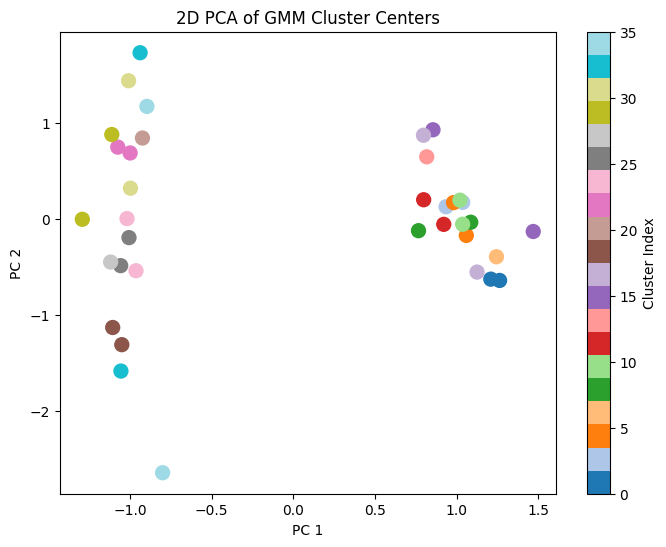

In [37]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming gmm is an instance of your ClassConditionalGMM
mu = gmm.mu.detach().cpu().numpy().squeeze(0)  # shape: (n_classes, latent_dim)

pca = PCA(n_components=2)
mu_2d = pca.fit_transform(mu)

plt.figure(figsize=(8, 6))
plt.scatter(mu_2d[:, 0], mu_2d[:, 1], s=100, c=np.arange(mu.shape[0]), cmap='tab20')

plt.title("2D PCA of GMM Cluster Centers")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Cluster Index")
plt.show()


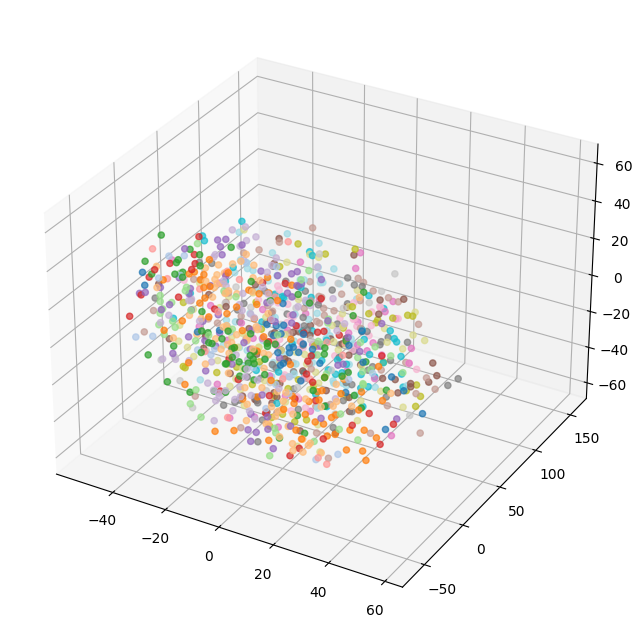

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_samples=1000
device = next(inn.parameters()).device
inn.eval()


Xs = []
Zs = []
Cs = []


count = 0
for x_batch, _ in train_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        z, _ = inn(x_batch)
    

    dist = cluster_distances(z, gmm.mu)
    log_probs = -0.5 * dist
    preds = log_probs.argmax(dim=1)
    
    Xs.append(x_batch.cpu())
    Zs.append(z.cpu())
    Cs.append(preds.cpu())
    
    count += x_batch.size(0)
    if count >= n_samples:
        break

Xs = torch.cat(Xs, dim=0)[:n_samples]
Zs = torch.cat(Zs, dim=0)[:n_samples]
Cs = torch.cat(Cs, dim=0)[:n_samples]

pca = PCA(n_components=50, random_state=42)
Z_pca = pca.fit_transform(Zs.numpy())


tsne = TSNE(n_components=3, perplexity=20, random_state=42)
Z_3d = tsne.fit_transform(Zs.numpy())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Z_3d[:, 0], Z_3d[:, 1], Z_3d[:, 2],
                     c=Cs.numpy(), cmap='tab20', alpha=0.7)

plt.show()




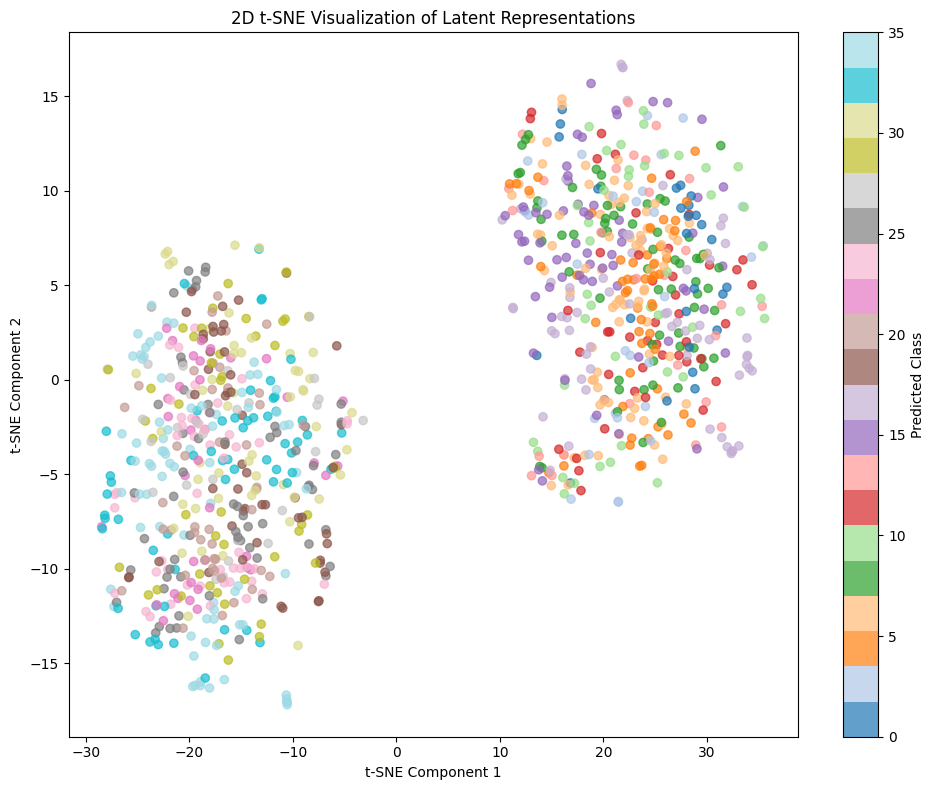

In [38]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_samples = 1000
device = next(inn.parameters()).device
inn.eval()

Xs = []
Zs = []
Cs = []

count = 0
for x_batch, _ in train_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        z, _ = inn(x_batch)
    
    dist = cluster_distances(z, gmm.mu)
    log_probs = -0.5 * dist
    preds = log_probs.argmax(dim=1)
    
    Xs.append(x_batch.cpu())
    Zs.append(z.cpu())
    Cs.append(preds.cpu())
    
    count += x_batch.size(0)
    if count >= n_samples:
        break

Xs = torch.cat(Xs, dim=0)[:n_samples]
Zs = torch.cat(Zs, dim=0)[:n_samples]
Cs = torch.cat(Cs, dim=0)[:n_samples]

# Optional: reduce dimensions with PCA before t-SNE (improves speed/stability)
pca = PCA(n_components=50, random_state=42)
Z_pca = pca.fit_transform(Zs.numpy())

# Run t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
Z_2d = tsne.fit_transform(Zs.numpy())

# Plot the 2D t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=Cs.numpy(), cmap='tab20', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("2D t-SNE Visualization of Latent Representations")
plt.colorbar(label="Predicted Class")
plt.tight_layout()
plt.show()


In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.patches import Rectangle

# Assume these variables are already defined:
# true_labels, predicted_labels, n_classes, output_dir

# --- Plot Confusion Matrix ---
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=range(n_classes), normalize='true')

plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, cmap='gray_r', annot=True, fmt='.2f',
                 square=True, cbar=True, linewidths=0,
                 xticklabels=range(n_classes),
                 yticklabels=range(n_classes))
num_rows, num_cols = conf_matrix.shape
rect = Rectangle((0, 0), num_cols, num_rows, fill=False, edgecolor='black', linewidth=2.5)
ax.add_patch(rect)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.close()

# --- Plot Per-Class Accuracy ---
class_accuracies = []
for class_idx in range(n_classes):
    mask = (true_labels == class_idx)
    if mask.sum() == 0:
        class_accuracies.append(0.0)
    else:
        correct = (predicted_labels[mask] == class_idx).sum()
        class_accuracies.append(correct / mask.sum())

class_accuracies = np.array(class_accuracies) * 100
overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100

sorted_indices = np.argsort(class_accuracies)[::-1]
sorted_accuracies = class_accuracies[sorted_indices]

plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

plt.figure(figsize=(12, 5))
x_positions = np.arange(len(sorted_accuracies))
plt.bar(x_positions, sorted_accuracies, color='blue', label='Accuracy')
plt.xticks(x_positions, sorted_indices, rotation=90)
plt.xlabel('Material/Class ID (sorted)')
plt.ylabel('Accuracy [%]')
mean_acc = np.mean(sorted_accuracies)
plt.axhline(y=mean_acc, color='gray', linestyle='--', label='Mean Accuracy')
plt.title(f'Per-Class Accuracy (Overall: {overall_accuracy:.2f}%)')
plt.legend()

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2.5)

plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'per_class_accuracy.png'))
plt.close()


NameError: name 'true_labels' is not defined